In [2]:
from __future__ import (absolute_import, division, print_function)
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from folium import folium
from folium.plugins import TimeSliderChoropleth
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import numpy as np
import geocoder
import re

from shapely.geometry import Point
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline

In [3]:
def get_lat_long(row, address = "Full Address", city = "CITY", state = "STATE"):
    string_list = []
    if row[address]:
        string_list.append(row[address])
    if row[city]:
        string_list.append(row[city])
    string_list.append("Los Angeles County")
    if row[state]:
        string_list.append(row[state])
    separator = ","
    full_string = separator.join(string_list)
    
    g = geocoder.arcgis(full_string)
    # Get latlng attribute from g
    # latlng is a list with two elements
    lat_lng_list = g.latlng
    #print(lat_lng_list)
    # Create default values for latitude and longitude
    latitude = 0.0
    longitude = 0.0
    # see if value returned by geocoder is within LA County
    # If so, replace default value with it
    if 33.6 <= lat_lng_list[0] <= 35.0:
        latitude = lat_lng_list[0]
    if -119.0 <= lat_lng_list[1] <= -117.6:
        longitude = lat_lng_list[1]
    # Populate the Lat and Long columns in the row
    #latitude = lat_lng_list[0]
    #longitude = lat_lng_list[1]
    row["Lat"] = latitude
    row["Long"] = longitude
    return row

In [4]:
#lat = re.compile('\d{2}\.\d*')
#long = re.compile('-\d*\.\d*')
# Regex with grouping to keep Lat and Long separate
latlong = re.compile('(\d{2}\.\d*), ?(-\d{3}\.\d*)')
#(34.0475, -118.323)

# Checks if Cross Street field is populated
# If so, combines with Address field and returns
# Otherwise returns original row
def combine_address_with_cross(row):
    if pd.notnull(row["Cross Street"]):
        combined_text = str(row["Address"]) + " and " + str(row["Cross Street"])
        row["Address"] = combined_text
        return row
    else:
        return row

# Checks if Location field has a null Lat/Long
# If so, runs combine_address_with_cross then geocodes result
# Returns geocoded row
def geocode_only_nulls(row):
    if row["Location"] == "(0.0, 0.0)":
        updated_row = combine_address_with_cross(row)
        geocoded_row = get_lat_long(updated_row, address = "Address", city = "Area Name", state = "STATE")
        return geocoded_row
    else:
        return row
        
# Takes string location and searches for Lat Long using regex
# Checks to be sure result is within LA County
#def split_lat_long(row):
#    lat_long_str = row["Location"]
#    print(lat_long_str)
#    latitude = lat.search(lat_long_str)
#    #print(latitude.group())
#    if latitude:
#        if 33.6 <= float(latitude.group()) <= 35.0:
#            row["Lat"] = latitude.group()
#    else:
#        row["Lat"] = "No Match"
#   longitude = long.search(lat_long_str)
#    #print(longitude.group())
#    if longitude:
#        if -119.0 <= float(longitude.group()) <= -117.6:
#            row["Long"] = longitude.group()
#    else:
#        row["Long"] = "No Match"
#    return row

# Takes string location and searches for Lat Long using regex
# Checks to be sure result is within LA County
def split_lat_long(row):
    lat_long_str = row["Location"]
    #print(lat_long_str)
    # Search Lat Long String with Regex
    latlongmatch = latlong.search(lat_long_str)
    # Check for match group 1 (Latitude)
    latitude = 0.0
    longitude = 0.0
    try:
        latitude = float(latlongmatch.group(1))
        #print("Latitude: " + str(latitude))
    except:
        pass
    # Check if returned latitude is within LA County Area
    try:
        if 33.6 <= latitude <= 35.0:
            row["Lat"] = latitude
    except:
        pass
    # Check for match group 2 (Longitude)
    try:
        longitude = float(latlongmatch.group(2))
        #print("Longitude: " + str(longitude))
    except:
        pass
    # Check if longitude is within LA County Area
    try:
        if -119.0 <= longitude <= -117.6:
            row["Long"] = longitude
    except:
        pass
    #print(str(row["Lat"]))
    #print(str(row["Long"]))
    return row

In [5]:
# Makes sure Lat Long Values are stored as floats
def convert_lat_long_to_float(row):
    row["Lat"] = float(row["Lat"])
    row["Long"] = float(row["Long"])
    return row

In [6]:
# Import arrest data from LAPD downloaded from City of LA Open Data Portal
raw_arrest_data = pd.read_csv("./Arrest_Data_from_2010_to_Present.csv", parse_dates = ["Arrest Date", "Time"])

In [7]:
raw_arrest_data.head()
#raw_arrest_data.shape
#raw_arrest_data["Charge Group Description"].unique()

,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,Charge Group Code,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location
0,191811472,2019-05-03,1700,18,Southeast,1802,23,F,B,NaN,NaN,M,653.22 PC,NaN,91ST,FIGUEROA,"(33.9543, -118.2827)"
1,5614161,2019-04-29,1040,8,West LA,842,41,M,H,3.0,Robbery,F,211PC,ROBBERY,11600 WILSHIRE BL,NaN,"(34.0508, -118.4592)"
2,5615197,2019-04-30,0615,6,Hollywood,663,27,M,O,5.0,Burglary,F,459PC,BURGLARY,LA BREA,LEXINGTON,"(34.0907, -118.3384)"
3,5615701,2019-04-30,1100,9,Van Nuys,901,2,F,H,NaN,NaN,D,300(B)WIC,NaN,RAYMER,SEPULVEDA BL,"(34.2149, -118.4674)"
4,5615929,2019-04-30,1550,20,Olympic,2049,41,M,W,4.0,Aggravated Assault,F,245(A)(2)PC,ADW W/FIREARM,8TH ST,VERMONT,"(34.0578, -118.2916)"


In [8]:
raw_arrest_data["Charge Group Description"].unique()

array([nan, 'Robbery', 'Burglary', 'Aggravated Assault',
       'Miscellaneous Other Violations', 'Drunkeness', 'Larceny',
       'Liquor Laws', 'Narcotic Drug Laws', 'Disorderly Conduct',
       'Prostitution/Allied', 'Disturbing the Peace',
       'Driving Under Influence', 'Gambling', 'Sex (except rape/prst)',
       'Fraud/Embezzlement', 'Receive Stolen Property', 'Other Assaults',
       'Homicide', 'Weapon (carry/poss)', 'Vehicle Theft',
       'Against Family/Child', 'Forgery/Counterfeit',
       'Moving Traffic Violations', 'Non-Criminal Detention', 'Rape',
       'Federal Offenses', 'Pre-Delinquency'], dtype=object)

In [9]:
#Filter Raw Arrest Data to only DUI Incidents.
dui_arrest_data = raw_arrest_data[raw_arrest_data["Charge Group Description"] == 'Driving Under Influence']

In [10]:
# See how many we are left with
dui_arrest_data.shape

(120603, 17)

In [11]:
# Reset Index of Filtered Data
dui_arrest_data = dui_arrest_data.reset_index()

In [12]:
# Create empty rows to store Lat and Long
# Assign new row for state value
dui_arrest_data['Lat'] = np.nan
dui_arrest_data['Long'] = np.nan
dui_arrest_data = dui_arrest_data.assign(STATE="California")

In [13]:
# Confirm new rows added.
dui_arrest_data.shape

(120603, 21)

In [14]:
dui_arrest_data.head()

,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location,Lat,Long,STATE
0,95,191008773,2019-04-20,1830,10,West Valley,1049,28,M,H,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,BURBANK BL,WOODLEY AV,"(34.1717, -118.4757)",NaN,NaN,California
1,183,5478957,2018-11-22,0940,8,West LA,827,21,F,W,...,Driving Under Influence,F,23153(A)VC,DUI ALCOHOL CAUSING INJURY,SAN VICENTE,BARRINGTON,"(34.0536, -118.4655)",NaN,NaN,California
2,202,5511360,2019-01-03,0116,7,Wilshire,717,39,M,B,...,Driving Under Influence,F,23153(A)VC,DUI ALCOHOL CAUSING INJURY,400 N LA BREA AV,NaN,"(34.0783, -118.3441)",NaN,NaN,California
3,213,5523557,2019-01-18,0150,7,Wilshire,784,35,M,B,...,Driving Under Influence,F,23153(A)VC,DUI ALCOHOL CAUSING INJURY,WASHINGTON BL,REDONDO ST,"(34.0412, -118.3528)",NaN,NaN,California
4,240,5551051,2019-02-19,1130,1,Central,122,38,F,W,...,Driving Under Influence,M,23152(B)VC,DRUNK DRIVING .10 OR ABOVE,100 N HILL ST,NaN,"(34.0572, -118.2481)",NaN,NaN,California


In [15]:
# Attempt to pull Lat Long from String values.
dui_arrest_data = dui_arrest_data.apply(split_lat_long, axis = 1)

In [16]:
# Check for rows where Latitude is still null.
test_lat_long = dui_arrest_data[dui_arrest_data["Lat"].isnull()]
test_lat_long.shape

(187, 21)

In [17]:
# Rows missing a Latitude appear to be those with (0.0, 0.0)
test_lat_long.head()

,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location,Lat,Long,STATE
147,2124,5613213,2019-04-28,0220,9,Van Nuys,995,29,F,W,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,SAN DIEGO FY,GETTY DR,"(0.0, 0.0)",NaN,NaN,California
677,8481,5638044,2019-05-24,0347,17,Devonshire,1733,27,M,H,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,HAYVENHURST,REGAN FY,"(0.0, 0.0)",NaN,NaN,California
4119,44027,5757800,2019-09-26,2127,14,Pacific,1400,23,M,H,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,10 FY,405 FY,"(0.0, 0.0)",NaN,NaN,California
5191,58615,2464438,2010-09-03,0330,9,Van Nuys,902,34,M,H,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,SEPULVEDA,GILMORE,"(0.0, 0.0)",NaN,NaN,California
5230,61341,2235703,2010-02-20,0030,2,Rampart,224,40,M,W,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,LA VETA TERRACE DR,SUNSET BL,"(0.0, 0.0)",NaN,NaN,California


In [18]:
# Run function to geocode rows with (0.0, 0.0) Lat Long
dui_arrest_data = dui_arrest_data.apply(geocode_only_nulls, axis = 1)

In [19]:
# No longer have rows with Null Latitude
dui_arrest_data[dui_arrest_data["Lat"].isnull()]

,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location,Lat,Long,STATE


In [20]:
# Make sure Lat Long values are float
dui_arrest_data = dui_arrest_data.apply(convert_lat_long_to_float, axis = 1)

In [21]:
dui_arrest_data["int_time"] = dui_arrest_data['Time'].astype(int)

In [22]:
dui_arrest_data.describe()

,index,Report ID,Area ID,Reporting District,Age,Charge Group Code,Lat,Long,int_time
count,1.206030e+05,1.206030e+05,120603.000000,120603.000000,120603.000000,120603.0,120603.000000,120603.000000,120603.000000
mean,8.380191e+05,4.069937e+06,11.307886,1179.200285,34.438231,22.0,34.095409,-118.363724,1117.277091
std,2.940283e+05,4.923199e+06,5.702602,572.085423,11.656282,0.0,0.107735,0.098771,900.166785
min,9.500000e+01,1.608103e+06,1.000000,100.000000,13.000000,22.0,33.706500,-118.666700,0.000000
25%,6.420675e+05,3.034826e+06,6.000000,667.000000,25.000000,22.0,34.027300,-118.437000,227.000000
50%,8.552080e+05,3.872868e+06,12.000000,1245.000000,31.000000,22.0,34.090800,-118.349500,1013.000000
75%,1.062324e+06,4.724706e+06,16.000000,1601.000000,42.000000,22.0,34.181700,-118.282050,2050.000000
max,1.314855e+06,1.921044e+08,21.000000,2199.000000,92.000000,22.0,34.706000,-117.716700,2400.000000


In [23]:
# Convert dataframe to geodataframe
dui_arrest_data_gdf = gpd.GeoDataFrame(
    dui_arrest_data, geometry=gpd.points_from_xy(dui_arrest_data.Long, dui_arrest_data.Lat))

# Convert Lat/Long data to projected Web Mercatur
dui_arrest_data_gdf.crs = {'init' :'epsg:4326'}
dui_arrest_data_gdf = dui_arrest_data_gdf.to_crs({'init': 'epsg:3857'})

In [24]:
# Filter to first 100 entries to run mapping test.
dui_arrest_data_gdf_for_mapping = dui_arrest_data_gdf.iloc[0:500]

In [25]:
# Load County outlines from LA Times
county = gpd.read_file("http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/counties-2012.geojson")
county = county.to_crs({'init': 'epsg:3857'})
# Filter to only display LA County
la_county = county[county["name"] == "Los Angeles"]
# Load City outline from LA Times
city = gpd.read_file("http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary/los-angeles-census-place-2012.geojson")
city = city.to_crs({'init': 'epsg:3857'})

In [26]:
city.head()

,kind,external_id,name,slug,set,metadata,resource_uri,geometry
0,Census Place (2012),Los Angeles,Los Angeles,los-angeles-census-place-2012,/1.0/boundary-set/census-places-2012/,"{'PCICBSA': 'Y', 'INTPTLAT': '+34.0193936', 'P...",/1.0/boundary/los-angeles-census-place-2012/,"MULTIPOLYGON (((-13210078.811 4053163.497, -13..."


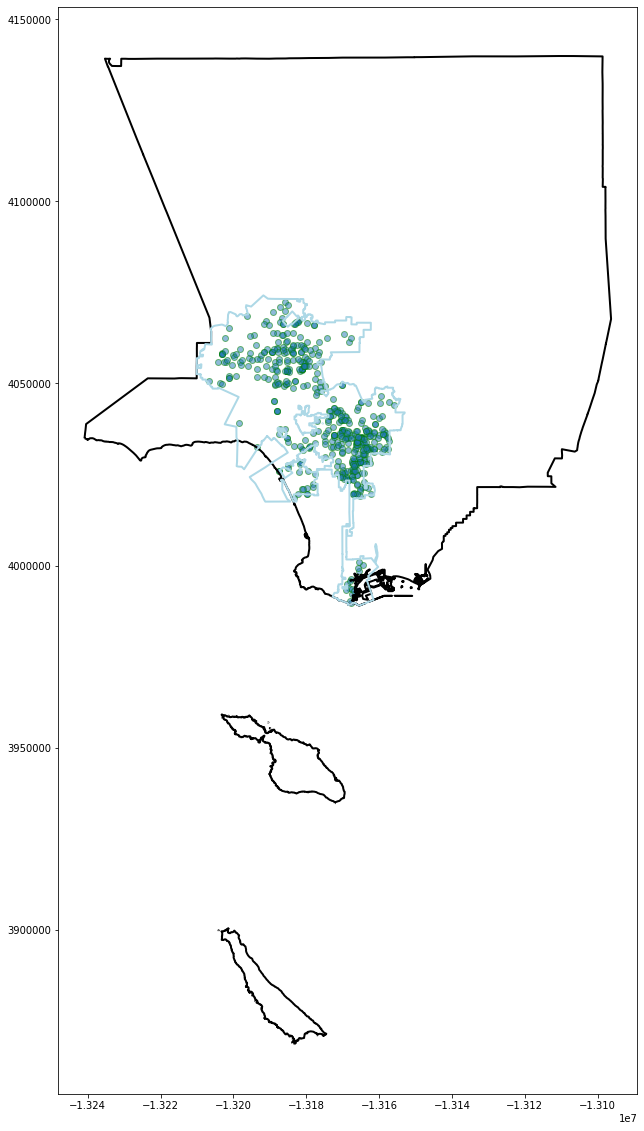

In [27]:
ax = la_county.geometry.boundary.plot(figsize=(20, 20),color=None,edgecolor='k',linewidth = 2)

#la_county.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2,ax=ax)

city.geometry.boundary.plot(color=None,edgecolor='lightblue',linewidth = 2,ax=ax)

dui_arrest_data_gdf_for_mapping.plot(figsize=(20, 20), alpha=0.5, edgecolor='green', ax = ax)

In [28]:
# Assembles List of Lists for Heat Map with Time plugin.
# Plugin currently not working, likely due to Leaflet update.
data_point_time_list=[]
# Create a list of 24 lists
# One for each hour of the day
for i in range(24):
    new_list = []
    data_point_time_list.append(new_list)
# Determine hour from Time and use as index to append to appropriate list
for index, row in dui_arrest_data_gdf.iterrows():
    time = row['Time']
    #print(time)
    hour = time[0:2]
    #Some data points list Midnight as 2400 while others list it as 0000
    if hour == '24':
        hour = '00'
    #print(int(hour))
    point = [row['Lat'],row['Long']]
    data_point_time_list[int(hour)].append(point)
    
#print(data_point_time_list)


In [29]:
my_map = folium.Map(location=[dui_arrest_data_gdf["Lat"].median(), dui_arrest_data_gdf["Long"].median()],
                       zoom_start=10, tiles='OpenStreetMap')

In [30]:
#HeatMapWithTime(data_point_time_list).add_to(my_map)

In [31]:
heat_data = [[row['Lat'],row['Long']] for index, row in dui_arrest_data_gdf_for_mapping.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(my_map)

# Display the map
my_map

In [32]:
new_map = folium.Map(location=[dui_arrest_data_gdf["Lat"].median(), dui_arrest_data_gdf["Long"].median()],
                       zoom_start=9, tiles='OpenStreetMap')

In [33]:
time_labels = ['Midnight - 1AM', '1AM to 2AM', '2AM to 3AM', '3AM to 4AM', '4AM to 5AM', '5AM to 6AM', '6AM to 7AM', '7AM to 8AM', '8AM to 9AM', '9AM to 10AM', '10AM to 11AM', '11AM to Noon', 'Noon to 1PM', '1PM - 2PM', '2PM - 3PM', '3PM - 4PM', '4PM - 5PM', '5PM - 6PM', '6PM - 7PM', '7PM - 8PM', '8PM - 9PM', '9PM - 10PM', '10PM - 11PM', '11PM - Midnight']
hm = plugins.HeatMapWithTime(data_point_time_list, index = time_labels, auto_play=True,max_opacity=0.8)

hm.add_to(new_map)
# Render the map
new_map.render()

In [34]:
# Jupyter Notebooks have difficulty displaying the map with so many data points. 
# Outputting to HTML file to view in browser separately.
new_map.save(outfile='index.html')

In [36]:
the_10 = gpd.read_file("./GISData/segments_for_buffering/10_downtown_to_405.geojson")
the_10 = the_10.to_crs({'init': 'epsg:3857'})

In [37]:
the_10_buffered = the_10
the_10_buffered["geometry"] = the_10.geometry.buffer(150)

In [38]:
the_10_buffered.head()

,FullName,Type,Elevation,Surface,Status,DrivingDir,From_L,From_R,To_L,To_R,...,LCity_R,NameCat_L,NameCat_R,Accuracy,Jurisdicti,Source,SourceID,UpdateDate,Shape_len,geometry
0,None,Ramp,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141601629,2015-05-07,571.813145,"POLYGON ((-13174714.263 4033380.996, -13174716..."
1,None,Ramp,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241170773,2015-05-07,151.341975,"POLYGON ((-13176692.643 4033407.255, -13176705..."
2,Interstate 10,Freeway,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,241170751,2015-04-19,86.049217,"POLYGON ((-13170129.716 4033656.647, -13170144..."
3,Santa Monica Frwy,Freeway,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,241170751,2015-04-19,86.049217,"POLYGON ((-13170129.716 4033656.647, -13170144..."
4,None,Ramp,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241170699,2015-05-07,70.403895,"POLYGON ((-13175267.766 4033244.189, -13175282..."


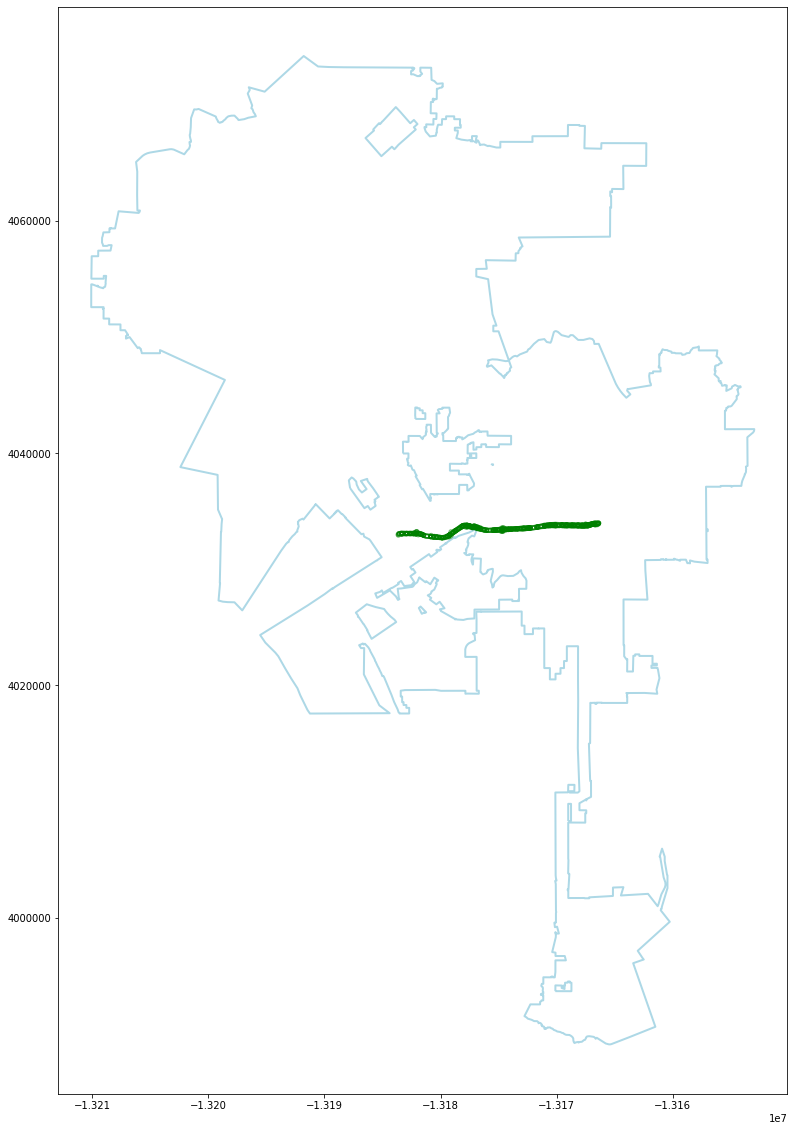

In [39]:
ax = city.geometry.boundary.plot(figsize=(20, 20),color=None,edgecolor='lightblue',linewidth = 2)

the_10_buffered.geometry.boundary.plot(alpha=0.5, edgecolor='green', ax = ax)

In [40]:
# Join DUI dataset to the freeway buffer.
join_duis_to_buffer = gpd.sjoin(dui_arrest_data_gdf, the_10_buffered, how='left', op='intersects', lsuffix='left', rsuffix='right')
# "Surface" field came from the buffer layer, so rows where it is null were outside the buffer
duis_on_the_10 = join_duis_to_buffer[join_duis_to_buffer["Surface"].notnull()]
print(duis_on_the_10.shape)
duis_on_the_10.head()

(28417, 56)


,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,LCity_L,LCity_R,NameCat_L,NameCat_R,Accuracy,Jurisdicti,Source,SourceID,UpdateDate,Shape_len
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241221193,2015-04-14,809.907539
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141607343,2015-04-14,1031.813655
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454036,2015-04-18,1046.975440


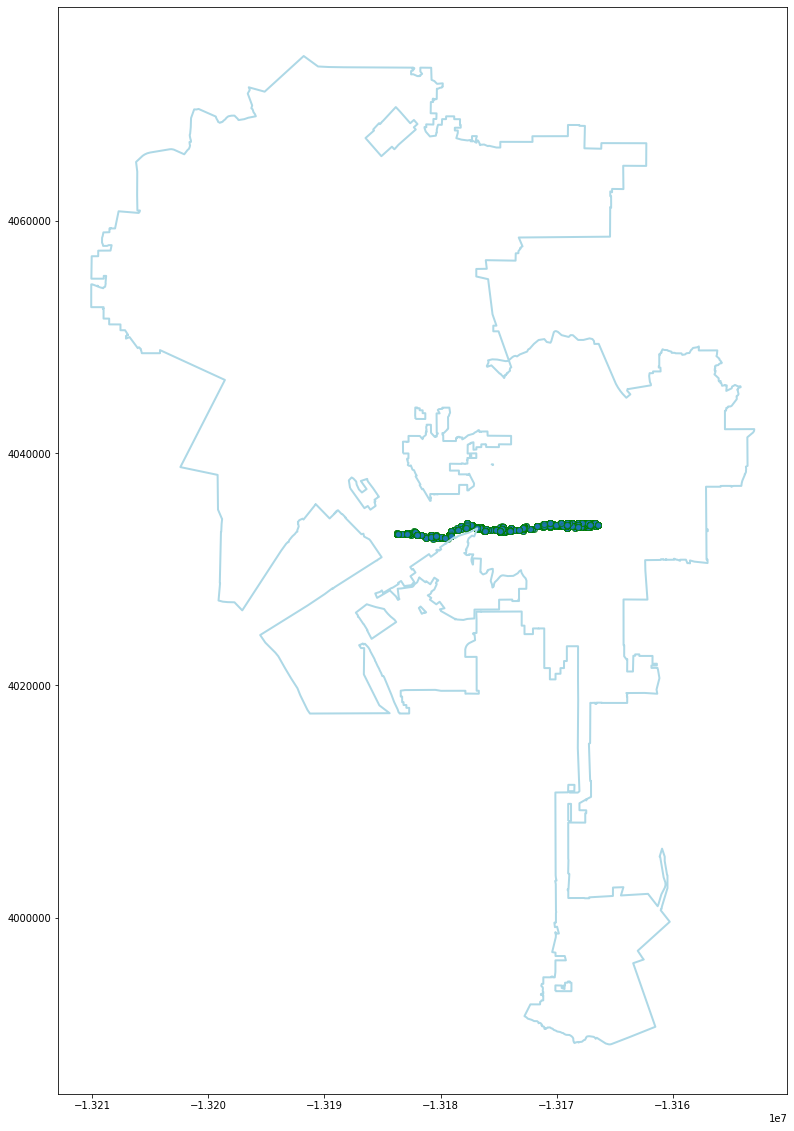

In [41]:
# Plot filtered dataset to make sure we're getting what we expect
ax = city.geometry.boundary.plot(figsize=(20, 20),color=None,edgecolor='lightblue',linewidth = 2)

duis_on_the_10.geometry.plot(alpha=0.5, edgecolor='green', ax = ax)

In [42]:
duis_on_the_10

,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,LCity_L,LCity_R,NameCat_L,NameCat_R,Accuracy,Jurisdicti,Source,SourceID,UpdateDate,Shape_len
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241221193,2015-04-14,809.907539
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141607343,2015-04-14,1031.813655
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454036,2015-04-18,1046.975440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120538,1314495,5609065,2019-04-24,0306,20,Olympic,2093,25,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,141606019,2015-04-19,1188.676021
120538,1314495,5609065,2019-04-24,0306,20,Olympic,2093,25,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141606009,2015-04-19,442.955575
120538,1314495,5609065,2019-04-24,0306,20,Olympic,2093,25,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,241229778,2015-04-19,1090.484000
120538,1314495,5609065,2019-04-24,0306,20,Olympic,2093,25,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,241229778,2015-04-19,1090.484000


In [43]:
duis_on_the_10["Arrest Date"] = duis_on_the_10["Arrest Date"].astype("datetime64")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


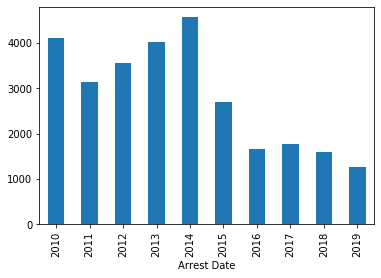

In [44]:
duis_on_the_10["Arrest Date"].groupby([duis_on_the_10["Arrest Date"].dt.year]).count().plot(kind="bar")

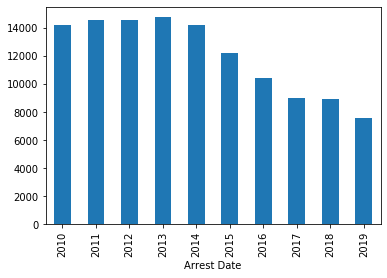

In [45]:
# Plot overall dui arrest data to compare with our area of interest.
dui_arrest_data["Arrest Date"].groupby([dui_arrest_data["Arrest Date"].dt.year]).count().plot(kind="bar")

# There is an overall downward trend in DUI's during the same timeframe.
## Is the change in our area of interest similar to the overall trend?

In [46]:
total_dui_by_year = dui_arrest_data["Arrest Date"].groupby([dui_arrest_data["Arrest Date"].dt.year]).count().astype(float)
total_dui_by_year

Arrest Date
2010    14193.0
2011    14584.0
2012    14574.0
2013    14775.0
2014    14248.0
2015    12244.0
2016    10468.0
2017     8992.0
2018     8918.0
2019     7607.0
Name: Arrest Date, dtype: float64

In [47]:
# Calculate % change year over year for total DUI's
total_change = (total_dui_by_year.pct_change())*100
total_change

Arrest Date
2010          NaN
2011     2.754879
2012    -0.068568
2013     1.379168
2014    -3.566836
2015   -14.065132
2016   -14.505064
2017   -14.100115
2018    -0.822954
2019   -14.700606
Name: Arrest Date, dtype: float64

In [48]:
i10_duis_by_year = duis_on_the_10["Arrest Date"].groupby([duis_on_the_10["Arrest Date"].dt.year]).count().astype(float)
i10_duis_by_year

Arrest Date
2010    4106.0
2011    3135.0
2012    3567.0
2013    4014.0
2014    4568.0
2015    2703.0
2016    1671.0
2017    1785.0
2018    1603.0
2019    1265.0
Name: Arrest Date, dtype: float64

In [49]:
aoi_change = (i10_duis_by_year.pct_change())*100
aoi_change

Arrest Date
2010          NaN
2011   -23.648320
2012    13.779904
2013    12.531539
2014    13.801694
2015   -40.827496
2016   -38.179800
2017     6.822262
2018   -10.196078
2019   -21.085465
Name: Arrest Date, dtype: float64

In [50]:
yearly_totals = pd.concat([total_dui_by_year, total_change, i10_duis_by_year, aoi_change], axis=1)
yearly_totals.columns=['Total DUI', 'Total Change', 'AOI DUI', 'AOI Change']
yearly_totals['Year'] = yearly_totals.index

In [51]:
yearly_totals.dropna()

,Total DUI,Total Change,AOI DUI,AOI Change,Year
Arrest Date,,,,,
2011,14584.0,2.754879,3135.0,-23.648320,2011
2012,14574.0,-0.068568,3567.0,13.779904,2012
2013,14775.0,1.379168,4014.0,12.531539,2013
2014,14248.0,-3.566836,4568.0,13.801694,2014
2015,12244.0,-14.065132,2703.0,-40.827496,2015
2016,10468.0,-14.505064,1671.0,-38.179800,2016
2017,8992.0,-14.100115,1785.0,6.822262,2017
2018,8918.0,-0.822954,1603.0,-10.196078,2018
2019,7607.0,-14.700606,1265.0,-21.085465,2019


In [52]:
yearly_totals["AOI DUI"].dtype

dtype('float64')

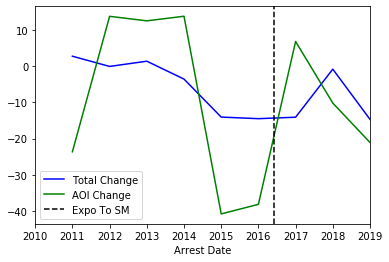

In [53]:
yearly_totals["Total Change"].plot(kind = "line", color='blue')
yearly_totals["AOI Change"].plot(kind = "line", color= 'green')
# Expo Line reached Santa Monica in May of 2016
# 5/12 = 0.4166666667 so using decimal to place marker line part way through the year.
plt.axvline(x=2016.4166666667, color= 'black', label = 'Expo To SM', linestyle = "--")
plt.legend()

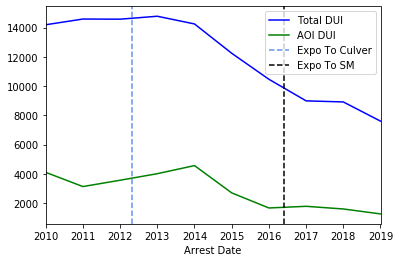

In [54]:
yearly_totals["Total DUI"].plot(kind = "line", color='blue')
yearly_totals["AOI DUI"].plot(kind = "line", color= 'green')
# Expo Line reached Santa Monica in May of 2016
# 5/12 = 0.4166666667 so using decimal to place marker line part way through the year.
plt.axvline(x=2012.3333333333, color= 'cornflowerblue', label = 'Expo To Culver', linestyle = "--")
plt.axvline(x=2016.4166666667, color= 'black', label = 'Expo To SM', linestyle = "--")

plt.legend(loc='upper right')

# Changes in the AOI are more extreme that overall changes. 
## The downward trend in DUI's also appears to start prior to the Expo Line reaching Santa Monica.
## Is this trend unique to this section of freeway?
## If not, is the change on the 10 Freeway comprable to changes on other freeway segments?

In [55]:
# Need to isolate DUI's in buffers of other freeways.
# Plot trend in each dataset together to compare.
# If Expo line isn't the source of the trend, what else could be a factor?
# How does the timing line up with the rise of Rideshare services?

### Need to bring in multiple layers
### Combining previous import into a function

In [56]:
def import_and_buffer(path, feet):
    gdf = gpd.read_file(path)
    gdf = gdf.to_crs({'init': 'epsg:3857'})
    buffered = gdf
    buffered["geometry"] = gdf.geometry.buffer(feet)
    return buffered

In [57]:
# Importing and Buffering Freeway Segments
# Using pronouns since this is LA
the_10 = import_and_buffer("./GISData/segments_for_buffering/10_downtown_to_405.geojson", 150)
the_5 = import_and_buffer("./GISData/segments_for_buffering/5_downtown_to_134.geojson", 150)
the_101 = import_and_buffer("./GISData/segments_for_buffering/101_downtown_to_north_hollywood.geojson", 150)
the_110 = import_and_buffer("./GISData/segments_for_buffering/110_downtown_to_pasadena.geojson", 150)
the_118 = import_and_buffer("./GISData/segments_for_buffering/118_from_405_to_ventura.geojson", 150)
the_405 = import_and_buffer("./GISData/segments_for_buffering/405_Sepulvida_Pass.geojson", 150)

In [58]:
# Addind the buffered segments to a dictionary so we can work with them as a group
segments = {}
segments["the_10"] = the_10
segments["the_5"] = the_5
segments["the_101"] = the_101
segments["the_110"] = the_110
segments["the_118"] = the_118
segments["the_405"] = the_405
#print(segments)

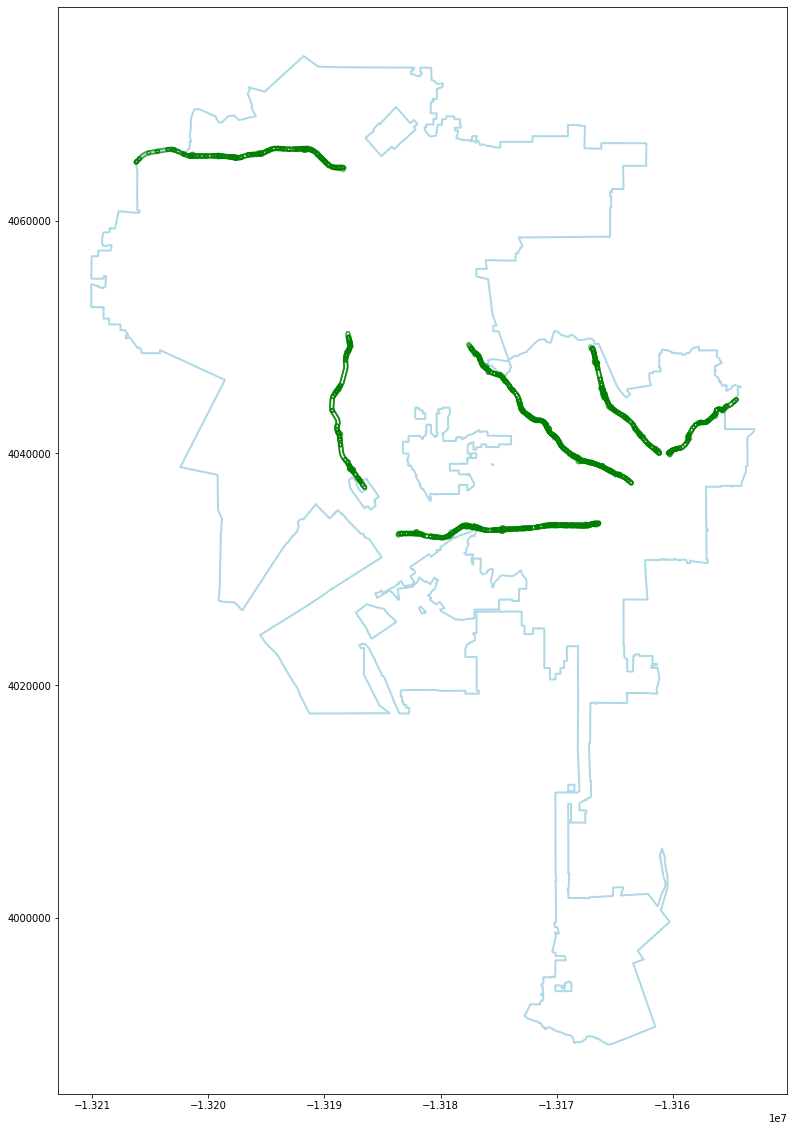

In [59]:
ax = city.geometry.boundary.plot(figsize=(20, 20),color=None,edgecolor='lightblue',linewidth = 2)

for freeway in segments.values():
    freeway.geometry.boundary.plot(alpha=0.5, edgecolor='green', ax = ax)

In [60]:
# Join DUI dataset to the freeway buffer.
join_duis_to_buffer = gpd.sjoin(dui_arrest_data_gdf, the_10, how='left', op='intersects', lsuffix='left', rsuffix='right')
# "Surface" field came from the buffer layer, so rows where it is null were outside the buffer
duis_on_the_10 = join_duis_to_buffer[join_duis_to_buffer["Surface"].notnull()]
print(duis_on_the_10.shape)
duis_on_the_10.head()

(28417, 56)


,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,LCity_L,LCity_R,NameCat_L,NameCat_R,Accuracy,Jurisdicti,Source,SourceID,UpdateDate,Shape_len
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241221193,2015-04-14,809.907539
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141607343,2015-04-14,1031.813655
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454036,2015-04-18,1046.975440


In [61]:
dui_dict = {}

for name, freeway in segments.items():
    print("Freeway Pulled")
    join_to_duis = gpd.sjoin(dui_arrest_data_gdf, freeway, how='left', op='intersects', lsuffix='left', rsuffix='right')
    duis_selected = join_to_duis[join_to_duis["Surface"].notnull()]
    print("DUIs Selected")
    print(duis_selected)
    dui_dict[name]= duis_selected
    

Freeway Pulled
DUIs Selected
          index  Report ID Arrest Date  Time  Area ID  Area Name  \
78         1455    5613205  2019-04-28  0425        3  Southwest   
78         1455    5613205  2019-04-28  0425        3  Southwest   
78         1455    5613205  2019-04-28  0425        3  Southwest   
78         1455    5613205  2019-04-28  0425        3  Southwest   
78         1455    5613205  2019-04-28  0425        3  Southwest   
...         ...        ...         ...   ...      ...        ...   
120538  1314495    5609065  2019-04-24  0306       20    Olympic   
120538  1314495    5609065  2019-04-24  0306       20    Olympic   
120538  1314495    5609065  2019-04-24  0306       20    Olympic   
120538  1314495    5609065  2019-04-24  0306       20    Olympic   
120538  1314495    5609065  2019-04-24  0306       20    Olympic   

        Reporting District  Age Sex Code Descent Code  ...      LCity_L  \
78                     309   31        M            H  ...  Los Angeles   
78  

DUIs Selected
          index  Report ID Arrest Date  Time  Area ID   Area Name  \
31         1159    5612028  2019-04-26  2225       11   Northeast   
943       10749    5644845  2019-05-31  0042        4  Hollenbeck   
943       10749    5644845  2019-05-31  0042        4  Hollenbeck   
943       10749    5644845  2019-05-31  0042        4  Hollenbeck   
943       10749    5644845  2019-05-31  0042        4  Hollenbeck   
...         ...        ...         ...   ...      ...         ...   
120350  1313352    5599935  2019-04-13  2310        4  Hollenbeck   
120431  1313926    5612254  2019-04-26  2355       11   Northeast   
120445  1314002    5612020  2019-04-26  2230       11   Northeast   
120465  1314111    5612301  2019-04-27  0100       11   Northeast   
120490  1314252    5611977  2019-04-26  2120       11   Northeast   

        Reporting District  Age Sex Code Descent Code  ...      LCity_L  \
31                    1177   39        M            H  ...  Los Angeles   
943    

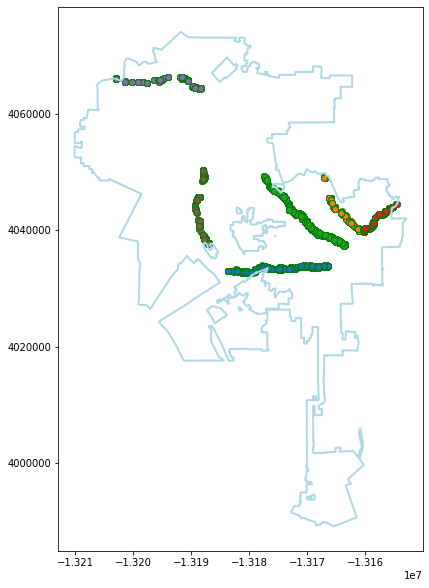

In [62]:
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)

for points in dui_dict.values():
    points.geometry.plot(alpha=0.5, edgecolor='green', ax = ax)


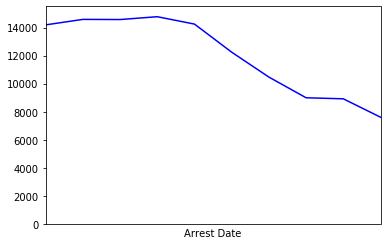

In [63]:
dui_arrest_data["Arrest Date"].groupby([dui_arrest_data["Arrest Date"].dt.year]).count().plot(kind="bar")
yearly_totals["Total DUI"].plot(kind = "line", color='blue')

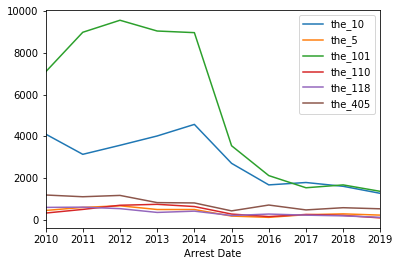

In [64]:
for name, points in dui_dict.items():
    points["Arrest Date"].groupby([points["Arrest Date"].dt.year]).count().plot(kind="line", label = name)
plt.legend(loc='upper right')

In [69]:
neighborhoods = gpd.read_file("./GISData/Neighborhood_Councils_Certified/Neighborhood_Councils_Certified.shp")
neighborhoods = neighborhoods.to_crs({'init': 'epsg:3857'})
neighborhoods.head()

,OBJECTID,NAME,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,SERVICE_RE,geometry
0,1,LINCOLN HEIGHTS NC,http://www.lincolnheightsnc.org/,http://empowerla.org/LHNC,LHNC@EmpowerLA.org,213-978-1551,47,2002-04-27T00:00:00.000Z,LINCOLN HEIGHTS NC,navigatela/reports/nc_reports.cfm?id=47,REGION 8 - NORTH EAST LA,"POLYGON ((-13158524.586 4036268.663, -13158638..."
1,2,VOICES OF 90037,https://www.voicesnc.org,https://empowerla.org/voicesof90037/,V9NC@EmpowerLA.org,213-978-1551,109,2008-06-16T00:00:00.000Z,VOICES OF 90037,navigatela/reports/nc_reports.cfm?id=109,REGION 9 - SOUTH LA 2,"POLYGON ((-13167174.935 4030298.989, -13167131..."
2,3,LOS FELIZ NC,http://www.losfeliznc.org/,http://empowerla.org/LFNC,LFNC@EmpowerLA.org,213-978-1551,36,2002-06-11T00:00:00.000Z,LOS FELIZ NC,navigatela/reports/nc_reports.cfm?id=36,REGION 7 - EAST,"POLYGON ((-13169127.631 4050028.421, -13168966..."
3,4,MISSION HILLS NC,http://mhnconline.org/,http://empowerla.org/MHNC,MHNC@EmpowerLA.org,213-978-1551,101,2005-04-19T00:00:00.000Z,MISSION HILLS NC,navigatela/reports/nc_reports.cfm?id=101,REGION 1 - NORTH EAST VALLEY,"POLYGON ((-13187947.126 4066529.147, -13187944..."
4,5,GREATER TOLUCA LAKE NC,http://www.gtlnc.org/,http://empowerla.org/GTLNC,GTLNC@EmpowerLA.org,213-978-1551,28,2002-09-10T00:00:00.000Z,GREATER TOLUCA LAKE NC,navigatela/reports/nc_reports.cfm?id=28,REGION 4 - SOUTH EAST VALLEY,"POLYGON ((-13175241.903 4050967.615, -13175252..."


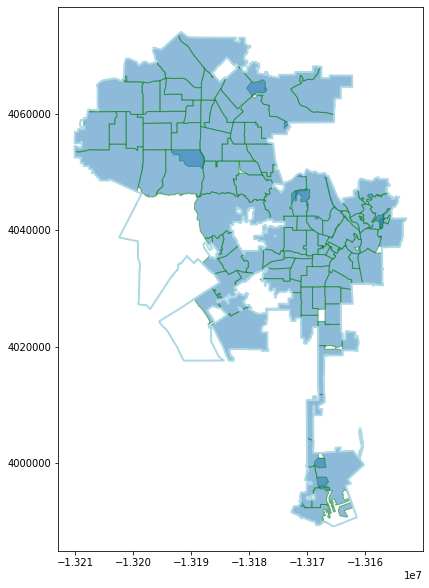

In [68]:
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
neighborhoods.geometry.plot(alpha=0.5, edgecolor='green', ax = ax)

In [76]:
dui_neighborhood_dict = {}

# For each row in the neighborhood DF, store the name as a variable and create a new DF of just that neighborhood.
# Join the Neighborhood DF to the dui DF and store the result in the dictionary with neighborhood name as key
for index, row in neighborhoods.iterrows():
    name = row["NAME"]
    neighborhood_df = neighborhoods[neighborhoods["NAME"] == name]
    join_to_duis = gpd.sjoin(dui_arrest_data_gdf, neighborhood_df, how='right', op='intersects', lsuffix='left', rsuffix='right')
    print("DUIs Selected")
    print(join_to_duis.head())
    dui_neighborhood_dict[name]= join_to_duis
    

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
0                 41383   724622    3207103  2012-06-26  0641        4   
0                 34574   673289    3004799  2012-01-07  0355        4   
0                 35106   677372    3014606  2012-01-15  0147        4   
0                109537  1222038    5197804  2018-01-06  2223        4   
0                 46970   765142    3366414  2012-11-11  0319        4   

              Area Name  Reporting District  Age Sex Code  ...  \
index_right                                                ...   
0            Hollenbeck                 401   22        M  ...   
0            Hollenbeck                 401   22        M  ...   
0            Hollenbeck                 401   22        F  ...   
0            Hollenbeck                 401   33        M  ...   
0            Hollenbeck                 401   31        M  ...   

    

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
3                111795  1240922    5278104  2018-04-07  0138       19   
3                 79676   985186    4245310  2015-02-21  0119       19   
3                 85113  1023758    4397301  2015-07-26  0414       19   
3                  6548   468522    2200474  2010-01-19  1700       19   
3                 28863   633523    2843858  2011-08-14  2105       19   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
3             Mission                1944   25        M  ...   
3             Mission                1944   33        F  ...   
3             Mission                1944   22        M  ...   
3             Mission                1944   33        M  ...   
3             Mission                1944   56        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
6                 16959   547979    2513983  2010-10-15  0220       16   
6                 89117  1053410    4513144  2015-11-30  0110       16   
6                  5516    64791    5534840  2019-01-30  2005       16   
6                 92286  1076570    4607550  2016-03-15  1405       16   
6                 91842  1073084    4592510  2016-02-28  0355       16   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
6            Foothill                1669   19        M  ...   
6            Foothill                1669   25        M  ...   
6            Foothill                1669   53        M  ...   
6            Foothill                1669   28        M  ...   
6            Foothill                1669   32        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
9                 75050   953365    4121651  2014-10-12  0045       10   
9                 74894   952380    4118920  2014-10-09  0405       10   
9                 43730   741027    3265161  2012-08-15  0235       10   
9                 48561   775432    3407793  2012-12-22  0230       10   
9                102748  1162450    4954244  2017-04-06  2225       10   

               Area Name  Reporting District  Age Sex Code  ...  \
index_right                                                 ...   
9            West Valley                1035   36        F  ...   
9            West Valley                1033   23        M  ...   
9            West Valley                1034   51        M  ...   
9            West Valley                1034   21        M  ...   
9            West Valley                1033   20        M  ...  

DUIs Selected
             index_left   index  Report ID Arrest Date  Time  Area ID  \
index_right                                                             
12                46960  765055    3362633  2012-11-08  0141       15   
12                60651  858084    3746566  2013-10-18  0250       15   
12                17493  551627    2529177  2010-10-29  0350       15   
12                68367  910403    3960582  2014-05-05  0056       15   
12                10396  498561    2316775  2010-05-01  0105       15   

               Area Name  Reporting District  Age Sex Code  ...  \
index_right                                                 ...   
12           N Hollywood                1566   26        M  ...   
12           N Hollywood                1567   41        F  ...   
12           N Hollywood                1567   30        M  ...   
12           N Hollywood                1551   32        M  ...   
12           N Hollywood                1566   27        M  ...   

    

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
15                69151   915335    3978453  2014-05-22  0220       14   
15               116650  1281347    5448619  2018-10-14  2329       14   
15                80300   990252    4268058  2015-03-14  0151       14   
15                84572  1019643    4383912  2015-07-13  0341       14   
15               107721  1206599    5134048  2017-10-21  0455       14   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
15            Pacific                1467   20        M  ...   
15            Pacific                1467   31        M  ...   
15            Pacific                1467   36        M  ...   
15            Pacific                1467   19        M  ...   
15            Pacific                1467   39        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
18                58357   842630    3668014  2013-08-23  2110        3   
18                32159   657062    2933608  2011-11-02  1800        3   
18                70981   927033    4031978  2014-07-14  1830        3   
18                94213  1093119    4671297  2016-05-21  1700        3   
18               100680  1144841    4883005  2017-01-15  2000        3   

             Area Name  Reporting District  Age Sex Code  ...  \
index_right                                               ...   
18           Southwest                 336   45        M  ...   
18           Southwest                 336   62        M  ...   
18           Southwest                 336   37        M  ...   
18           Southwest                 336   42        M  ...   
18           Southwest                 336   35        M  ...   

           

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
21               109765  1223948    5204469  2018-01-14  1849       11   
21                30837   646580    2893494  2011-09-29  0845       11   
21                41535   725625    3211625  2012-06-29  1548       11   
21               116884  1283244    5464834  2018-11-03  1710       11   
21                30737   645967    2886780  2011-11-06  0211       11   

             Area Name  Reporting District  Age Sex Code  ... WADDRESS  \
index_right                                               ...            
21           Northeast                1145   24        M  ...     NULL   
21           Northeast                1145   55        M  ...     NULL   
21           Northeast                1133   37        M  ...     NULL   
21           Northeast                1145   47        M  ...     NULL   
21           Northeast 

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
24                88843  1051385    4506362  2015-11-20  2250        7   
24                46165   758843    3340702  2012-10-20  0020        7   
24                78359   975991    4209733  2015-01-17  0025        7   
24                28211   628966    2824093  2011-07-28  1030        7   
24                58131   841101    3655617  2013-08-13  0035        7   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
24           Wilshire                 701   40        F  ...   
24           Wilshire                 701   29        M  ...   
24           Wilshire                 701   31        F  ...   
24           Wilshire                 701   36        M  ...   
24           Wilshire                 701   33        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
27                37332   693826    3077726  2012-03-07  1835        5   
27                97474  1119177    4776467  2016-09-09  2350        5   
27                39285   708412    3135614  2012-04-26  2230        5   
27               104065  1174051    5002326  2017-05-30  0930        5   
27                72754   938499    4070654  2014-08-21  0225        5   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
27             Harbor                 513   24        M  ...   
27             Harbor                 509   36        M  ...   
27             Harbor                 509   55        M  ...   
27             Harbor                 509   17        M  ...   
27             Harbor                 509   32        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
30                69701   919330    3997901  2014-06-08  1735        5   
30                 6013   464797    2187182  2010-01-07  2245        5   
30                 4585    49725    5771587  2019-10-12  0750        5   
30                 3103    34138    5718759  2019-08-15  2120        5   
30                89950  1058881    4534311  2015-12-26  0414        5   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
30             Harbor                 558   32        M  ...   
30             Harbor                 583   27        F  ...   
30             Harbor                 584   39        M  ...   
30             Harbor                 583   68        M  ...   
30             Harbor                 583   34        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
33                 2919    31880    5717702  2019-08-14  1720        5   
33                19828   568562    2594063  2011-01-01  0030        5   
33                37805   697423    3092814  2012-03-21  0045        5   
33                96832  1114022    4756880  2016-08-20  1920        5   
33                94379  1094912    4683112  2016-06-02  1955        5   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
33             Harbor                 558   23        M  ...   
33             Harbor                 558   28        M  ...   
33             Harbor                 558   34        M  ...   
33             Harbor                 558   30        F  ...   
33             Harbor                 558   23        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
36                 8901   487230    2269595  2010-03-21  0115       15   
36                82890  1008276    4334692  2015-05-23  0156       15   
36                90633  1063600    4553489  2016-01-17  0346       15   
36                93600  1087646    4645373  2016-04-25  0225       15   
36                49622   782514    3435450  2013-01-19  0234       15   

               Area Name  Reporting District  Age Sex Code  ...  \
index_right                                                 ...   
36           N Hollywood                1546   25        F  ...   
36           N Hollywood                1553   22        M  ...   
36           N Hollywood                1553   26        F  ...   
36           N Hollywood                1553   22        M  ...   
36           N Hollywood                1553   30        M  ...  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
39                87797  1043301    4475564  2015-10-17  2310       11   
39               119451  1306785    5567716  2019-03-09  0131       11   
39               109844  1224596    5210236  2018-01-21  0258       11   
39                86329  1032022    4429763  2015-08-30  2358       11   
39                44432   746274    3287107  2012-09-02  0228       11   

             Area Name  Reporting District  Age Sex Code  ...  \
index_right                                               ...   
39           Northeast                1102   33        M  ...   
39           Northeast                1102   48        F  ...   
39           Northeast                1102   51        M  ...   
39           Northeast                1102   36        M  ...   
39           Northeast                1102   27        M  ...   

           

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
42                90893  1065656    4566598  2016-01-30  1925       18   
42                96533  1111931    4750619  2016-08-14  0316       18   
42                26853   619267    2796113  2011-07-02  1920       12   
42                74385   948789    4103514  2014-09-21  1840       12   
42                54604   817275    3568451  2013-05-22  1950       12   

               Area Name  Reporting District  Age Sex Code  ... WADDRESS  \
index_right                                                 ...            
42             Southeast                1804   55        M  ...     NULL   
42             Southeast                1804   24        M  ...     NULL   
42           77th Street                1269   36        M  ...     NULL   
42           77th Street                1269   46        M  ...     NULL   
42         

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
45                98510  1127669    4807960  2016-10-15  2201       17   
45               104955  1181648    5030218  2017-06-30  0248       17   
45                92768  1080512    4617123  2016-03-25  2008       17   
45                97034  1115615    4762972  2016-08-26  2215       17   
45               105238  1184055    5038045  2017-07-08  2225       17   

              Area Name  Reporting District  Age Sex Code  ...  \
index_right                                                ...   
45           Devonshire                1701   32        M  ...   
45           Devonshire                1701   22        F  ...   
45           Devonshire                1701   28        F  ...   
45           Devonshire                1701   40        F  ...   
45           Devonshire                1701   29        M  ...   

    

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
48                38119   700204    3108200  2012-04-03  1112       13   
48                28427   630623    2835461  2011-08-06  2345       13   
48               110394  1229734    5229998  2018-02-11  1259       13   
48                13318   520268    2404965  2010-07-15  2355       13   
48                74533   949759    4109444  2014-09-28  0105       13   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
48             Newton                1365   35        M  ...   
48             Newton                1364   44        M  ...   
48             Newton                1364   38        M  ...   
48             Newton                1365   41        M  ...   
48             Newton                1364   31        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
51                82266  1003773    4319946  2015-05-08  2100        3   
51                58436   843079    3667995  2013-08-23  2220        3   
51                 2675    29270    5711954  2019-08-08  2200        3   
51                69761   919706    4002187  2014-06-12  2015        3   
51                34076   670303    2983080  2011-12-17  2325        3   

             Area Name  Reporting District  Age Sex Code  ...  \
index_right                                               ...   
51           Southwest                 361   23        M  ...   
51           Southwest                 361   27        F  ...   
51           Southwest                 361   37        M  ...   
51           Southwest                 361   19        M  ...   
51           Southwest                 361   68        M  ...   

           

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
54                52386   801717    3508935  2013-03-28  0117        6   
54                88209  1046744    4493526  2016-09-25  0231        6   
54                74037   946239    4090843  2015-02-22  0257        6   
54                 4571    49580    5772935  2019-10-14  0248        6   
54                36177   685831    3043789  2012-02-09  0915        6   

             Area Name  Reporting District  Age Sex Code  ...  \
index_right                                               ...   
54           Hollywood                 648   45        M  ...   
54           Hollywood                 648   32        M  ...   
54           Hollywood                 648   22        M  ...   
54           Hollywood                 648   30        M  ...   
54           Hollywood                 647   31        M  ...   

           

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
57                89184  1053882    4518964  2015-12-06  2120       11   
57                 6774   470328    2208415  2010-01-27  1340       11   
57                28534   631286    2834825  2011-08-06  0745       11   
57                27450   623391    2811185  2011-07-16  0333       15   
57                29952   640629    2872077  2011-09-10  0053       11   

               Area Name  Reporting District  Age Sex Code  ...  \
index_right                                                 ...   
57             Northeast                1115   61        F  ...   
57             Northeast                1115   46        M  ...   
57             Northeast                1115   42        M  ...   
57           N Hollywood                1589   21        M  ...   
57             Northeast                1109   30        M  ...  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
60               104193  1174992    5000890  2017-05-28  1545        2   
60                84354  1018311    4375012  2015-07-04  0036        2   
60                78106   973868    4200965  2015-01-07  0255        2   
60                  393     4764    5471421  2018-11-12  0757        2   
60                87869  1043908    4482779  2015-10-25  1810        2   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
60            Rampart                 246   36        M  ...   
60            Rampart                 246   31        M  ...   
60            Rampart                 246   22        M  ...   
60            Rampart                 246   33        M  ...   
60            Rampart                 246   50        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
63                85642  1027215    4413810  2015-08-13  0235        2   
63               112915  1250389    5319096  2018-05-22  2220        2   
63                75035   953239    4119596  2014-10-09  1933        2   
63                26066   613753    2771154  2011-06-10  1515        2   
63               116517  1280014    5441759  2018-10-06  1410        2   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
63            Rampart                 235   47        M  ...   
63            Rampart                 236   23        F  ...   
63            Rampart                 236   25        M  ...   
63            Rampart                 236   27        F  ...   
63            Rampart                 236   33        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
66                50011   785623    3442984  2013-01-26  1915        9   
66                94876  1099228    4700821  2016-06-21  1115        9   
66                75952   959826    4144452  2014-11-05  0010        9   
66                60045   853457    3726091  2013-09-27  2315        9   
66                37840   697694    3093489  2012-03-21  1550        9   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
66           Van Nuys                 926   52        M  ...   
66           Van Nuys                 919   29        M  ...   
66           Van Nuys                 919   46        M  ...   
66           Van Nuys                 916   28        M  ...   
66           Van Nuys                 916   33        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
69               102853  1163250    4955387  2017-04-08  0110       14   
69                54161   814297    3553965  2013-05-09  0545       14   
69                58063   840690    3659951  2013-08-16  1400       14   
69                40813   720253    3187680  2012-06-09  0405       19   
69                62960   873484    3804865  2013-12-16  0925       14   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
69            Pacific                1406   23        F  ...   
69            Pacific                1407   23        M  ...   
69            Pacific                1407   28        M  ...   
69            Mission                1907   27        M  ...   
69            Pacific                1407   23        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
72                86328  1032019    4434300  2015-09-04  0600       17   
72                29787   639633    2864941  2011-09-03  0355       17   
72                34929   676315    3014582  2012-01-15  0104       17   
72                 6966   471557    2212492  2010-01-30  1430       17   
72                72839   939111    4067784  2014-08-18  0001       17   

              Area Name  Reporting District  Age Sex Code  ...  \
index_right                                                ...   
72           Devonshire                1727   18        M  ...   
72           Devonshire                1727   21        M  ...   
72           Devonshire                1727   33        M  ...   
72           Devonshire                1728   23        M  ...   
72           Devonshire                1728   18        M  ...   

    

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
75                43745   741126    3269621  2012-08-18  0950        2   
75                31443   651503    2908453  2011-10-12  2100        2   
75                76305   962599    4158734  2014-11-16  1515       20   
75                48690   776129    3407358  2012-12-21  2131       20   
75                86871  1035851    4447220  2015-09-18  0005       20   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
75            Rampart                 241   24        M  ...   
75            Rampart                 241   24        M  ...   
75            Olympic                2029   25        M  ...   
75            Olympic                2029   20        M  ...   
75            Olympic                2029   46        M  ...   

                  

DUIs Selected
             index_left   index  Report ID Arrest Date  Time  Area ID  \
index_right                                                             
78                22986  591463    2686290  2011-03-26  0035        9   
78                52312  801253    3503516  2013-03-23  2332        9   
78                14223  527359    2432342  2010-08-07  2106        9   
78                74148  946956    4098466  2014-09-17  0022        9   
78                 6412  467645    2197337  2010-01-16  0051       19   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
78           Van Nuys                 974   43        M  ...   
78           Van Nuys                 974   18        F  ...   
78           Van Nuys                 974   18        M  ...   
78           Van Nuys                 974   27        M  ...   
78            Mission                1995   48        F  ...   

                         

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
81                79689   985260    4247373  2015-02-23  2010       20   
81                23599   596293    2701546  2011-04-08  2150       20   
81                21262   578277    2635526  2011-02-07  0135       20   
81                86513  1033349    4436539  2015-09-06  2020       20   
81                81549   998827    4301535  2015-04-17  2300       20   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
81            Olympic                2022   30        M  ...   
81            Olympic                2022   36        F  ...   
81            Olympic                2022   69        F  ...   
81            Olympic                2022   52        M  ...   
81            Olympic                2022   45        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
84               109353  1220356    5192573  2018-01-01  0855       20   
84                49203   779654    3422099  2013-01-06  2235       20   
84               117307  1287615    5482756  2018-11-27  1520       20   
84                67130   901257    3908128  2014-03-28  0235       20   
84                30209   642502    2879436  2011-09-17  0210       20   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
84            Olympic                2029   63        M  ...   
84            Olympic                2029   23        M  ...   
84            Olympic                2029   22        M  ...   
84            Olympic                2029   39        F  ...   
84            Olympic                2029   31        M  ...   

                  

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
87               112036  1243196    5287498  2018-04-17  1915       11   
87                99476  1135564    4839143  2016-11-21  0420       11   
87               118471  1297550    5525150  2019-01-19  1930       11   
87                96738  1113288    4754167  2016-08-18  0005       11   
87                45409   753754    3314564  2012-09-26  2025       11   

             Area Name  Reporting District  Age Sex Code  ...  \
index_right                                               ...   
87           Northeast                1158   42        M  ...   
87           Northeast                1147   41        M  ...   
87           Northeast                1147   26        F  ...   
87           Northeast                1147   37        M  ...   
87           Northeast                1148   49        M  ...   

           

DUIs Selected
             index_left   index  Report ID Arrest Date  Time  Area ID  \
index_right                                                             
90                51470  795306    3484273  2013-03-06  1600        8   
90                50555  789153    3459539  2013-02-12  0315        8   
90                17568  552201    2530194  2010-10-29  2345        8   
90                13492  521841    2410767  2010-07-21  0301        8   
90                31111  648941    2906119  2011-10-10  2200        8   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
90            West LA                 858   33        M  ...   
90            West LA                 859   43        M  ...   
90            West LA                 897   32        F  ...   
90            West LA                 858   20        M  ...   
90            West LA                 859   31        M  ...   

                         

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
93               115524  1271730    5405660  2018-08-26  2254       11   
93               116278  1277605    5437304  2018-10-01  0846       11   
93               116139  1276337    5430046  2018-09-23  0506       11   
93               118667  1299433    5530554  2019-01-26  0201       11   
93                89806  1057902    4532985  2015-12-23  2055       11   

             Area Name  Reporting District  Age Sex Code  ...  \
index_right                                               ...   
93           Northeast                1145   29        F  ...   
93           Northeast                1145   38        M  ...   
93           Northeast                1145   28        M  ...   
93           Northeast                1145   41        M  ...   
93           Northeast                1145   63        M  ...   

           

DUIs Selected
             index_left    index  Report ID Arrest Date  Time  Area ID  \
index_right                                                              
96                 3368    36808    5732908  2019-08-30  2120        1   
96                79045   980466    4232223  2015-02-06  0515        1   
96               112064  1243495    5285087  2018-04-14  2218        1   
96                 1497    16671    5666357  2019-06-21  2315        1   
96                32879   661930    2957901  2011-11-23  2020        1   

            Area Name  Reporting District  Age Sex Code  ...  \
index_right                                              ...   
96            Central                 158   43        M  ...   
96            Central                 159   22        M  ...   
96            Central                 158   29        F  ...   
96            Central                 158   28        M  ...   
96            Central                 159   26        M  ...   

                  

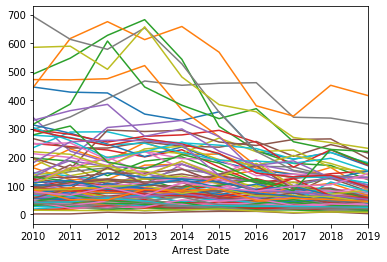

In [78]:
for name, points in dui_neighborhood_dict.items():
    points["Arrest Date"].groupby([points["Arrest Date"].dt.year]).count().plot(kind="line", label = name)
#plt.legend(loc='upper right')

In [140]:
# Too Much data for a graph to effectively communicate. Try a chloropleth map.
# Add Column to neighborhoods gdf and calculate area.
# Select DUI's in each neighborhood and select by year. Populate column with DUI's/sqkm
neighborhoods["Area"] = neighborhoods["geometry"].area/1000000

In [141]:
# CRS uses meeters, so Area should be in Square Meters
neighborhoods.crs

{'init': 'epsg:3857'}

In [142]:
#Creating Columns to Hold Annual DUI Statistics
nan_value = float("NaN")
neighborhoods["2010"] = nan_value
neighborhoods["2011"] = nan_value
neighborhoods["2012"] = nan_value
neighborhoods["2013"] = nan_value
neighborhoods["2014"] = nan_value
neighborhoods["2015"] = nan_value
neighborhoods["2016"] = nan_value
neighborhoods["2017"] = nan_value
neighborhoods["2018"] = nan_value
neighborhoods["2019"] = nan_value
neighborhoods.head()

,OBJECTID,NAME,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,1,LINCOLN HEIGHTS NC,http://www.lincolnheightsnc.org/,http://empowerla.org/LHNC,LHNC@EmpowerLA.org,213-978-1551,47,2002-04-27T00:00:00.000Z,LINCOLN HEIGHTS NC,navigatela/reports/nc_reports.cfm?id=47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,VOICES OF 90037,https://www.voicesnc.org,https://empowerla.org/voicesof90037/,V9NC@EmpowerLA.org,213-978-1551,109,2008-06-16T00:00:00.000Z,VOICES OF 90037,navigatela/reports/nc_reports.cfm?id=109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,LOS FELIZ NC,http://www.losfeliznc.org/,http://empowerla.org/LFNC,LFNC@EmpowerLA.org,213-978-1551,36,2002-06-11T00:00:00.000Z,LOS FELIZ NC,navigatela/reports/nc_reports.cfm?id=36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,MISSION HILLS NC,http://mhnconline.org/,http://empowerla.org/MHNC,MHNC@EmpowerLA.org,213-978-1551,101,2005-04-19T00:00:00.000Z,MISSION HILLS NC,navigatela/reports/nc_reports.cfm?id=101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,GREATER TOLUCA LAKE NC,http://www.gtlnc.org/,http://empowerla.org/GTLNC,GTLNC@EmpowerLA.org,213-978-1551,28,2002-09-10T00:00:00.000Z,GREATER TOLUCA LAKE NC,navigatela/reports/nc_reports.cfm?id=28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
def calculate_annual_duis_per_sqkm(row):
    name = row["NAME"]
    neighborhood_gdf = neighborhoods[neighborhoods["NAME"] == name]
    neighborhood_duis = gpd.sjoin(neighborhood_gdf, dui_arrest_data_gdf, how='left', op='intersects', lsuffix='left', rsuffix='right')
    years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"]
    for year in years:
        annual_dui = neighborhood_duis[neighborhood_duis["Arrest Date"].dt.year == int(year)]
        annual_total = len(annual_dui.index)
        annual_normalized = annual_total/row["Area"]
        row[year] = annual_normalized
    return row
    
#DataFrame.apply(self, func, axis=0,

In [144]:
neighborhoods_populated = neighborhoods.apply(calculate_annual_duis_per_sqkm, axis=1)

In [145]:
neighborhoods_populated.head()

,OBJECTID,NAME,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,1,LINCOLN HEIGHTS NC,http://www.lincolnheightsnc.org/,http://empowerla.org/LHNC,LHNC@EmpowerLA.org,213-978-1551,47,2002-04-27T00:00:00.000Z,LINCOLN HEIGHTS NC,navigatela/reports/nc_reports.cfm?id=47,...,5.328365,4.495808,8.908361,4.828831,5.161854,4.912087,4.579064,5.328365,4.912087,3.746507
1,2,VOICES OF 90037,https://www.voicesnc.org,https://empowerla.org/voicesof90037/,V9NC@EmpowerLA.org,213-978-1551,109,2008-06-16T00:00:00.000Z,VOICES OF 90037,navigatela/reports/nc_reports.cfm?id=109,...,20.271584,27.797561,22.699318,30.468069,25.369826,25.612600,19.664650,16.994142,16.265822,15.173341
2,3,LOS FELIZ NC,http://www.losfeliznc.org/,http://empowerla.org/LFNC,LFNC@EmpowerLA.org,213-978-1551,36,2002-06-11T00:00:00.000Z,LOS FELIZ NC,navigatela/reports/nc_reports.cfm?id=36,...,2.163471,2.019239,2.105778,3.634631,2.423087,1.644238,1.384621,1.240390,1.471160,0.865388
3,4,MISSION HILLS NC,http://mhnconline.org/,http://empowerla.org/MHNC,MHNC@EmpowerLA.org,213-978-1551,101,2005-04-19T00:00:00.000Z,MISSION HILLS NC,navigatela/reports/nc_reports.cfm?id=101,...,7.240770,8.557274,7.313909,6.728797,6.509379,7.094492,9.142387,6.655658,4.754041,5.046598
4,5,GREATER TOLUCA LAKE NC,http://www.gtlnc.org/,http://empowerla.org/GTLNC,GTLNC@EmpowerLA.org,213-978-1551,28,2002-09-10T00:00:00.000Z,GREATER TOLUCA LAKE NC,navigatela/reports/nc_reports.cfm?id=28,...,13.696523,12.818541,16.857259,15.276891,15.276891,11.940558,6.672665,7.550647,4.916701,6.321472


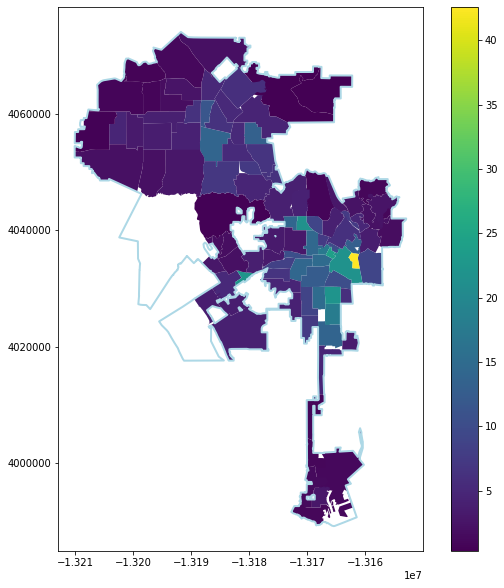

In [148]:
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
neighborhoods_populated.plot(column='2019',ax=ax, legend=True)

In [149]:
#df.sort_values(by='col1', ascending=False)
neighborhoods_populated.sort_values(by='2019', ascending=False)

,OBJECTID,NAME,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
96,103,HISTORIC CULTURAL NC,http://www.hcncla.org/,http://empowerla.org/HCNC,HCNC@EmpowerLA.org,213-978-1551,46,2002-04-27T00:00:00.000Z,HISTORIC CULTURAL NC,navigatela/reports/nc_reports.cfm?id=46,...,23.678237,19.781818,28.473829,19.482094,33.269422,27.574656,24.277686,29.373003,30.871625,42.560882
64,65,WESTLAKE SOUTH NC,https://www.wsncla.org,https://empowerla.org/wsnc/,WSNC@EmpowerLA.org,213-978-1551,121,2011-06-07T00:00:00.000Z,WESTLAKE SOUTH NC,navigatela/reports/nc_reports.cfm?id=121,...,32.210875,32.210875,33.302769,31.664928,42.037922,34.394663,41.491975,27.297352,20.745987,24.021670
69,70,PALMS NC,http://palmsla.org/,http://empowerla.org/PALMSNC,PalmsNC@EmpowerLA.org,213-978-1551,115,2004-12-14T00:00:00.000Z,PALMS NC,navigatela/reports/nc_reports.cfm?id=115,...,18.429146,17.312228,17.032998,17.870687,12.286097,15.357621,10.889950,11.727638,31.552931,22.338358
92,93,ZAPATA KING NC,http://www.zapatakingnc.org/,http://empowerla.org/ZKNC,None,213-978-1551,125,2015-02-03T00:00:00.000Z,ZAPATA KING NC,navigatela/reports/nc_reports.cfm?id=125,...,34.997044,38.899592,23.037622,19.890406,26.310727,22.534068,14.980749,10.322869,28.576723,22.156402
71,72,DOWNTOWN LOS ANGELES,http://dlanc.com/,http://empowerla.org/DLANC,DLANC@EmpowerLA.org,213-978-1551,52,2002-04-27T00:00:00.000Z,DOWNTOWN LOS ANGELES,navigatela/reports/nc_reports.cfm?id=52,...,23.302112,32.329056,35.425508,32.119127,34.533310,29.809909,19.943249,18.053889,23.721970,21.832609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,46,PORTER RANCH NC,http://www.prnc.org/,http://empowerla.org/PRNC,PRNC@EmpowerLA.org,213-978-1551,114,2003-07-01T00:00:00.000Z,PORTER RANCH NC,navigatela/reports/nc_reports.cfm?id=114,...,1.916064,1.824822,1.094893,1.231755,1.094893,1.186135,1.049273,1.049273,0.729929,0.729929
76,77,BEL AIR-BEVERLY CREST NC,http://babcnc.org/,http://empowerla.org/BABCNC,BABCNC@EmpowerLA.org,213-978-1551,64,2002-10-08T00:00:00.000Z,BEL AIR-BEVERLY CREST NC,navigatela/reports/nc_reports.cfm?id=64,...,0.776092,0.496699,0.698483,0.667439,0.543265,0.558786,0.589830,0.419090,0.512221,0.636396
41,42,WEST HILLS NC,http://www.westhillsnc.org/,http://empowerla.org/WHNC,WHNC@EmpowerLA.org,213-978-1551,11,2002-01-22T00:00:00.000Z,WEST HILLS NC,navigatela/reports/nc_reports.cfm?id=11,...,0.846833,1.326706,0.903289,1.157339,1.044428,1.016200,1.185567,1.016200,0.762150,0.564556
8,9,FOOTHILL TRAILS DISTRICT NC,http://www.ftdnc.org/,http://empowerla.org/FTDNC,FTDNC@EmpowerLA.org,213-978-1551,9,2003-03-25T00:00:00.000Z,FOOTHILL TRAILS DISTRICT NC,navigatela/reports/nc_reports.cfm?id=9,...,0.938658,0.857036,0.625772,0.598565,0.884243,0.789017,0.775414,0.666584,0.789017,0.421716


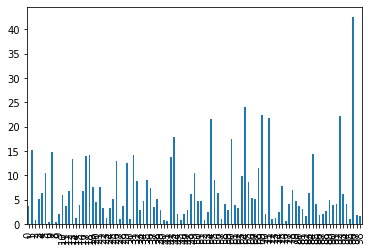

In [159]:
neighborhoods_populated["2019"].plot(kind="bar")

In [ ]:
# Examine change from 2013 to 2016
# See what parts of the city it was concentrated in

In [ ]:
#https://data.ca.gov/dataset/annual-average-daily-traffic-volumes
# Compare trend to traffic count trend over those years to see if there is another explanation
# Compare overall trend on freeways as well as trend on the 10